In [1]:
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import uniform
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
from numpy.polynomial import legendre

In [2]:
def intensity(t,history,parameters):    #left continue
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    intensity=0
    for i in range(len(history)):
        if history[i]>=t:
            break
        intensity+=alpha*np.exp(-beta*(t-history[i]))
    return mu+intensity

In [3]:
def hawkes_simulation_expo(T,parameters):
    t=0
    jump=0
    points_homo=[]
    points_hawkes=[]
    while(t<T):
        points_homo.append(t)
        intensity_sup=intensity(t,points_hawkes,parameters)+jump
        r=expon.rvs(scale=1/intensity_sup) #scale=1/lamda
        t+=r
        D=uniform.rvs(loc=0,scale=1)
        if D*intensity_sup<=intensity(t,points_hawkes,parameters):
            points_hawkes.append(t)
            jump=parameters[1]
        else:
            jump=0
    if points_hawkes[-1]>T:
        del points_hawkes[-1]
    del points_homo[0]
    return points_hawkes

In [4]:
def negtiveloglikelyhood1(parameters, times, T): #times=timestamp t1-tn; T is timespan      fast:R(i)
    times=np.array(times)
    
    mu=parameters[0]
    alpha=parameters[1]
    beta=parameters[2]
    
    timedifference=T-times #T-t0...T-t(n-1) 
    timeexponential=np.exp(-beta*timedifference)-1
    secondsum=alpha/beta*sum(timeexponential)
    
    R=np.zeros((len(times),1))
    for i in range(1,len(times)):
        R[i]=np.exp(-beta*(times[i]-times[i-1]))*(1+R[i-1])
    firstsum=sum(np.log(mu+alpha*R))  #left-continuous
    
    negtivelogl=-(firstsum-mu*T+secondsum)
    return negtivelogl

In [5]:
T=1000

In [6]:
points_hawkes=hawkes_simulation_expo(T,[1,1,2])

In [7]:
len(points_hawkes)

1937

In [8]:
parameters=np.array([1.2,0.7,3])
res=optimize.minimize(negtiveloglikelyhood1, parameters,args=(points_hawkes,T), method='SLSQP', bounds=((0.01,5),(0.01,5),(0.01,5)), options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 450.8291406585013
            Iterations: 12
            Function evaluations: 66
            Gradient evaluations: 12


In [9]:
res.x

array([ 0.97456843,  0.9967184 ,  2.00516043])

In [10]:
Lamda=len(points_hawkes)/T # first order stats

In [11]:
Lamda

1.937

In [12]:
def hawkes_second_stats(points_hawkes, M, T_g, T): # divide T_g into M bins, discrete
    g=np.zeros((1,M), dtype=float)[0]
    delta_t=T_g/M
    N=len(points_hawkes)
    Lamda=N/T # first order stats
    for m in range(M): # for m-th bin
        rate=np.zeros((1,N))[0]  #every point has a contribution to m-th g, but some contribution is 0
        div_num=0
        for i in range(N):
            if (T-points_hawkes[i])<(m+1)*delta_t:
                break
            else:
                div_num+=1
                for j in range(i+1,N):
                    interval=points_hawkes[j]-points_hawkes[i]
                    if interval<=(m+1)*delta_t and interval>m*delta_t:
                        rate[i]+=1
                    if interval>(m+1)*delta_t:
                        break
                rate[i]=rate[i]/delta_t
        if div_num==0:
            break
        else:
            g[m]=sum(rate)/div_num
    return g-Lamda, np.linspace(delta_t/2,T_g-delta_t/2,M)

In [13]:
def hawkes_second_stats_theory(t,points_hawkes,T): # if we know parameters, the 2nd-order stats of hawkes
    N=len(points_hawkes)
    Lamda=N/T # first order stats
    rate=np.zeros((1,N))[0]
    div_num=0
    for i in range(N):
        if T-points_hawkes[i]<t:
            break
        else:
            div_num+=1
            rate[i]=intensity(points_hawkes[i]+t,points_hawkes,[1,1,2])
    return sum(rate)/div_num-Lamda

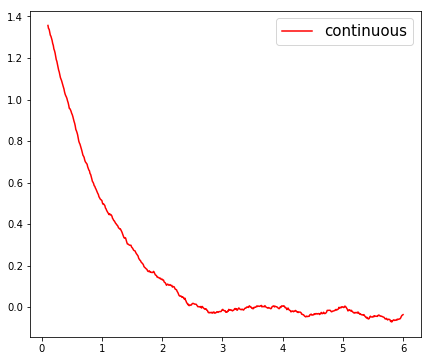

In [17]:
plt.figure(3,figsize=(7,6))
axs=plt.subplot(111)
x=np.linspace(0.1,6,600)
axs.plot(x,[hawkes_second_stats_theory(x_i,points_hawkes,T) for x_i in x],'r-',label='continuous')
plt.legend(fontsize=15)
plt.show()

In [13]:
def hawkes_second_stats_conti_gauss(t,h,points_hawkes,T):   # gaussian kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(((t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h)**2/2))
            g_t_i.append(sum(g_t)/np.sqrt(2*np.pi)/h)
    return np.average(g_t_i)-Lamda

In [14]:
def hawkes_second_stats_conti_expo(t,h,points_hawkes,T): # exponential kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=np.exp(-(np.abs(t-(points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i]))/h))/2
            g_t_i.append(sum(g_t)/h)
    return np.average(g_t_i)-Lamda

In [15]:
def fun_01(t,h,y): # 0-1 kernel
    y=np.array(y)
    return 0.5*np.array([a and b for a, b in zip((y-t)<np.array([h]*len(y)), (y-t)>=np.array([-h]*len(y)))])

In [16]:
def hawkes_second_stats_conti_01(t,h,points_hawkes,T):  #0_1 kernel
    N=len(points_hawkes)
    Lamda=N/T
    g_t_i=[]
    for i in range(N):
        if points_hawkes[i]+t>T-h:
            break
        else:
            g_t=fun_01(t,h,points_hawkes[:i]+points_hawkes[i+1:]-points_hawkes[i])
            g_t_i.append(sum(g_t)/h)
    return np.average(g_t_i)-Lamda

In [13]:
%%time
g,x=hawkes_second_stats(points_hawkes,60,6,T)

Wall time: 532 ms


In [21]:
g_01=[hawkes_second_stats_conti_01(x_i,0.05,points_hawkes,T) for x_i in x]

In [22]:
g_exp=[hawkes_second_stats_conti_expo(x_i,0.05,points_hawkes,T) for x_i in x]

In [23]:
g_gauss=[hawkes_second_stats_conti_gauss(x_i,0.05,points_hawkes,T) for x_i in x]

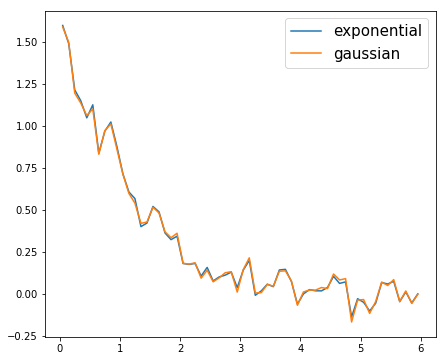

In [32]:
plt.figure(3,figsize=(7,6))
axs=plt.subplot(111)
# axs.plot(x,g,'bo',label='bin')
# axs.plot(x,g_01,'g-',label='0-1')
axs.plot(x,g_exp,'-',label='exponential')
axs.plot(x,g_gauss,'-',label='gaussian')
# axs.plot(x,[hawkes_second_stats_conti_01(x_i,0.05,points_hawkes,T) for x_i in x],'r-',label='continuous')
# axs.plot(x,np.exp(-x),'m-',label='groudtruth')
plt.legend(fontsize=15)
plt.show()

In [14]:
def primitive_g(t,g,range_g): # -infinity to t
    delta_t=range_g/len(g)
    num_bin=t/delta_t
    if num_bin<len(g):
        integral=sum(g[:int(num_bin)])*delta_t+g[int(num_bin)]*delta_t*(num_bin-int(num_bin))
    else:
        integral=sum(g)*delta_t
    return integral+sum(g)*delta_t

In [15]:
def gq_points_weights(a,b,Q):
    p,w=np.polynomial.legendre.leggauss(Q)
    c = np.array([0]*Q + [1])
    p_new=(a+b+(b-a)*p)/2
    w_new=(b-a)/(legendre.legval(p, legendre.legder(c))**2*(1-p**2))
    return p_new,w_new

In [16]:
def phi(t,g,Q,range_g): 
    delta_t=range_g/len(g) 
    p,w=gq_points_weights(0,range_g,Q)  # (0,infininty) replaced by (0,range_g)
    g_ti=np.zeros((Q,Q))
    G_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        G_ti[i]=primitive_g(p[i],g,range_g)
        for j in range(i,Q):
            if i==j:
                g_ti[i][i]=g[int(p[i]/delta_t)]
            else:
                g_ti[i][j]=g[int((p[j]-p[i])/delta_t)]
                g_ti[j][i]=g_ti[i][j]
    
    a = np.zeros((Q,Q))
    b = np.zeros((1,Q))[0]
    for i in range(Q):
        b[i]=g_ti[i][i]
        for j in range(Q):
            if i==j:
                a[i][i]=1+G_ti[i]-sum(w*g_ti[i])+w[i]*g_ti[i][i]  #diagonal
            else:
                a[i][j]=w[j]*g_ti[i][j]    
    phi_ti = np.linalg.solve(a,b)

    g_t=g[int(t/delta_t)]
    G_t=primitive_g(t,g,range_g)
    g_t_ti=np.zeros((1,Q))[0]
    for i in range(Q):
        g_t_ti[i]=g[int((t-p[i])/delta_t)]
    phi_t=(g_t-sum(w*phi_ti*g_t_ti))/(1+G_t-sum(w*g_t_ti))
    return phi_t

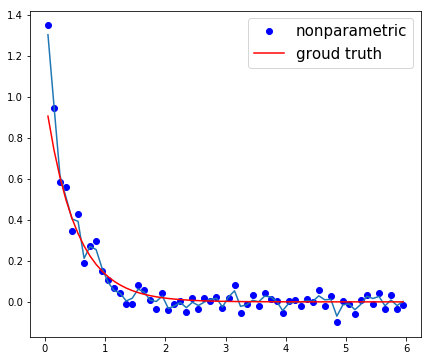

In [38]:
plt.figure(3,figsize=(7,6))
axs=plt.subplot(111)
axs.plot(x,[phi(xi,g,100,6) for xi in x],'bo',label='nonparametric')
axs.plot(x,[phi(xi,g_gauss,100,6) for xi in x],'-')
axs.plot(x,1*np.exp(-2*x),'r-',label='groud truth')
plt.legend(fontsize=15)
plt.show()

In [25]:
def phi_parameter(h,Q,range_g):# default range_g*10 points
    x=np.linspace(0.1/2,range_g-0.1/2,range_g*10)
    g_gauss=[hawkes_second_stats_conti_gauss(x_i,h,points_hawkes,T) for x_i in x]
    phi_result=[phi(xi,g_gauss,Q,range_g) for xi in x]
    
#     mse=sum((np.array(phi_result)-1*np.exp(-2*x))**2)/(range_g*10)
    
#     plt.figure(3,figsize=(7,6))
#     axs=plt.subplot(111)
#     axs.plot(x,phi_result,'-',label='nonparametric')
#     axs.plot(x,1*np.exp(-2*x),'r-',label='groud truth')
#     plt.legend(fontsize=15)
#     plt.show()
#     return mse
    return phi_result

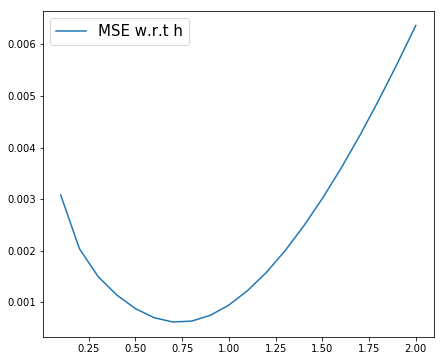

In [46]:
plt.figure(3,figsize=(7,6))
axs=plt.subplot(111)
axs.plot(np.linspace(0.1,2,20),[phi_parameter(h,100,6) for h in np.linspace(0.1,2,20)],label='MSE w.r.t h')
plt.legend(fontsize=15)
plt.show()

In [18]:
%%time
phi_mh=phi_parameter(0.7,100,6)

Wall time: 40.8 s


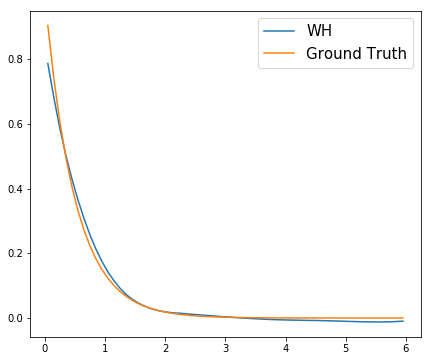

In [24]:
plt.figure(3,figsize=(7,6))
axs=plt.subplot(111)
axs.plot(np.linspace(0.1/2,6-0.1/2,6*10),phi_mh,label='WH')
axs.plot(np.linspace(0.1/2,6-0.1/2,6*10),1*np.exp(-2*np.linspace(0.1/2,6-0.1/2,6*10)),label='Ground Truth')
plt.legend(fontsize=15)
plt.show()